In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt  #Altair is a declarative statistical visualization library for Python

import statsmodels.api as sm 

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
bse_data = yf.download('^BSESN', start='2015-01-01', end='2020-06-30')

[*********************100%%**********************]  1 of 1 completed


In [6]:
unseenbse_data = yf.download('^BSESN', start='2020-06-30', end='2020-07-01')

[*********************100%%**********************]  1 of 1 completed


In [7]:
bse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
unseenbse_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [9]:
bse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

In [10]:
unseenbse_data.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adjclose', 'Volume': 'volume'}, inplace = True)

In [11]:
bse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2015-01-02 to 2020-06-29
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1345 non-null   float64
 1   high      1345 non-null   float64
 2   low       1345 non-null   float64
 3   close     1345 non-null   float64
 4   adjclose  1345 non-null   float64
 5   volume    1345 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.6 KB


In [12]:
unseenbse_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1 entries, 2020-06-30 to 2020-06-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      1 non-null      float64
 1   high      1 non-null      float64
 2   low       1 non-null      float64
 3   close     1 non-null      float64
 4   adjclose  1 non-null      float64
 5   volume    1 non-null      int64  
dtypes: float64(5), int64(1)
memory usage: 56.0 bytes


In [14]:
bse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [15]:
unseenbse_data.head()

,open,high,low,close,adjclose,volume
Date,,,,,,
2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [16]:
bse_data.reset_index(inplace=True)

In [17]:
bse_data.rename(columns={'Date': 'date'}, inplace = True)

In [18]:
bse_data.head()

,date,open,high,low,close,adjclose,volume
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200


In [19]:
unseenbse_data.reset_index(inplace=True)

In [20]:
unseenbse_data.rename(columns={'Date': 'date'}, inplace = True)

In [22]:
unseenbse_data.head()

,date,open,high,low,close,adjclose,volume
0,2020-06-30,35168.300781,35233.910156,34812.800781,34915.800781,34915.800781,18500


In [23]:
bse_data['date'] = pd.to_datetime(bse_data['date'], format = '%Y%m%d')

In [24]:
unseenbse_data['date'] = pd.to_datetime(unseenbse_data['date'], format = '%Y%m%d')

In [25]:
#before moving forward let us calculate first the actual price
unseenbsedata_price = round((unseenbse_data['high'] + unseenbse_data['low'] + unseenbse_data['close'])/ 3, 2)
unseenbsedata_price  #actual price

0    34987.5
dtype: float64

In [26]:
def stock_weekmovingavg(wks, df):
  dateclose_data = pd.DataFrame({'date': df['date'], 'close':df['close']})
  dateclose_data.set_index('date', inplace=True)
  num = wks * 5                                 #calculating the number of days in the week. 5 days because BSE is open for 5 days / week
  dateclose_data['movingavg'] = dateclose_data['close'].rolling(window=num).mean().shift()
  return dateclose_data.dropna()

In [27]:
stock_weekmovingavg(4, bse_data).head()

,close,movingavg
date,,
2015-02-02,29122.269531,28256.509570
2015-02-03,29000.140625,28318.228027
2015-02-04,28883.109375,28376.119043
2015-02-05,28850.970703,28470.901465
2015-02-06,28717.910156,28568.008984


<Axes: xlabel='date'>

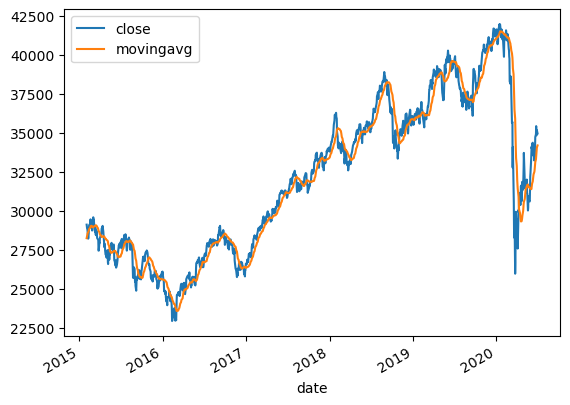

In [28]:
stock_weekmovingavg(4, bse_data).plot()

In [29]:
altdata_fourweek = stock_weekmovingavg(4, bse_data)
altdata_fourweek.reset_index(inplace=True)
altdata_fourweek.rename(columns={list(altdata_fourweek)[0]:'date'}, inplace=True)

In [30]:
alt.Chart(altdata_fourweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

In [31]:
stock_weekmovingavg(16, bse_data).head()

,close,movingavg
date,,
2015-05-05,27440.140625,28447.880933
2015-05-06,26717.369141,28442.283936
2015-05-07,26599.109375,28428.222046
2015-05-08,27105.390625,28423.367651
2015-05-11,27507.300781,28425.824780


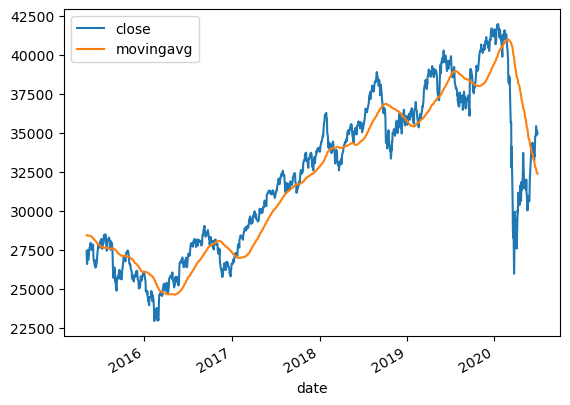

In [32]:
stock_weekmovingavg(16, bse_data).plot()
plt.show()

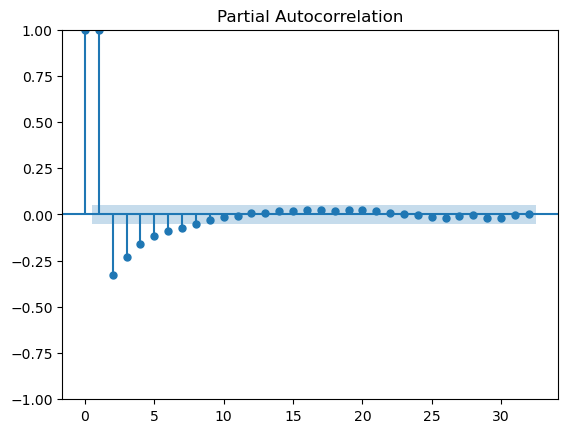

In [34]:
plotfourweek = altdata_fourweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfourweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fourweek['date']))) 
del plotfourweek['date']
sm.graphics.tsa.plot_pacf(plotfourweek.values.squeeze())
plt.show()

In [36]:
altdata_sixteenweek = stock_weekmovingavg(16, bse_data)
altdata_sixteenweek.reset_index(inplace=True)
altdata_sixteenweek.rename(columns={list(altdata_sixteenweek)[0]:'date'}, inplace=True)

In [37]:
alt.Chart(altdata_sixteenweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

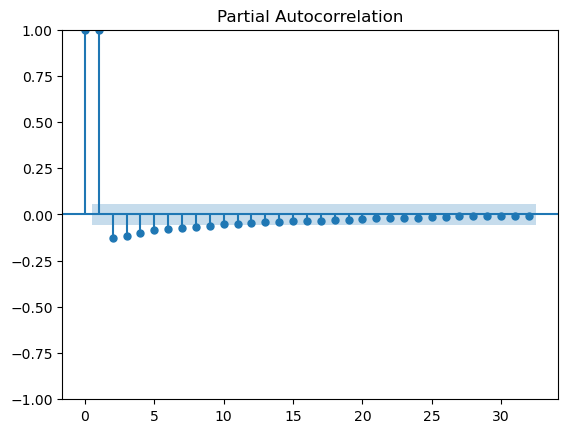

In [38]:
plotsixteenweek = altdata_sixteenweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotsixteenweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_sixteenweek['date']))) 
del plotsixteenweek['date']
sm.graphics.tsa.plot_pacf(plotsixteenweek.values.squeeze())
plt.show()

In [39]:
stock_weekmovingavg(52, bse_data).head()

,close,movingavg
date,,
2016-01-25,24485.949219,27198.907963
2016-01-27,24492.390625,27185.823535
2016-01-28,24469.570312,27172.939190
2016-01-29,24870.689453,27163.254995
2016-02-01,24824.830078,27155.416031


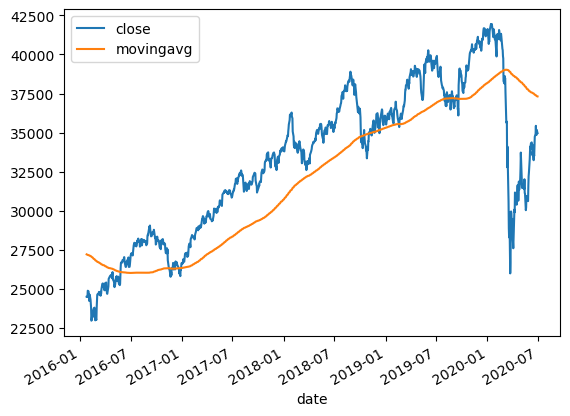

In [40]:
stock_weekmovingavg(52, bse_data).plot()
plt.show()

In [41]:
altdata_fiftytwoweek = stock_weekmovingavg(52, bse_data)
altdata_fiftytwoweek.reset_index(inplace=True)
altdata_fiftytwoweek.rename(columns={list(altdata_fiftytwoweek)[0]:'date'}, inplace=True)

In [42]:
alt.Chart(altdata_fiftytwoweek).mark_point().encode(
    x='date',
    y='movingavg'
)

alt.Chart(...)

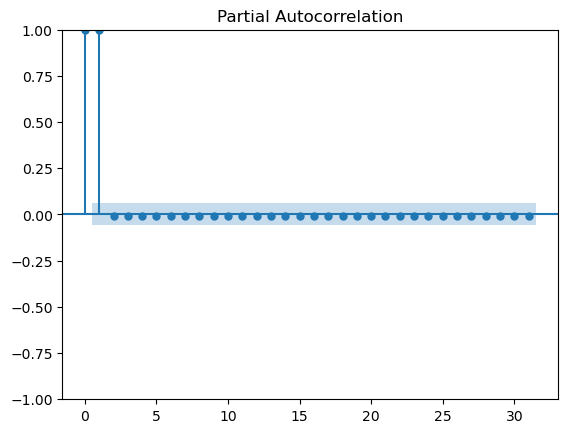

In [43]:
plotfiftytwoweek = altdata_fiftytwoweek.filter(['date', 'movingavg'], axis=1) #df.copy()
plotfiftytwoweek.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_fiftytwoweek['date']))) 
del plotfiftytwoweek['date']
sm.graphics.tsa.plot_pacf(plotfiftytwoweek.values.squeeze())
plt.show()

In [44]:
def rollingwindows(days, df):
  data = df.filter(['date','open','high','low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  rollingwindows_data = data.rolling(window=days).mean().shift()
  return rollingwindows_data.dropna()

In [45]:
rollingwindows(10, bse_data).head()

,open,high,low,close
date,,,,
2015-01-16,27515.904883,27657.483008,27279.612891,27479.296484
2015-01-19,27569.437891,27681.345898,27322.217969,27502.695508
2015-01-20,27596.578906,27708.302930,27363.268945,27544.664453
2015-01-21,27659.640820,27821.338867,27502.047852,27724.385352
2015-01-22,27845.606836,28011.988867,27703.692969,27922.389258


<Axes: xlabel='date'>

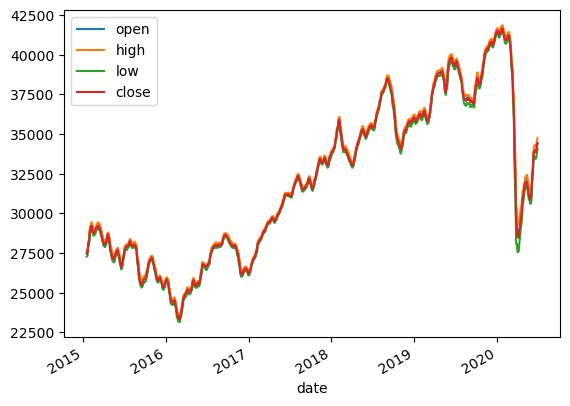

In [46]:
rollingwindows(10, bse_data).plot()

In [47]:
altdata_tendays = rollingwindows(10, bse_data)
altdata_tendays.reset_index(inplace=True)
altdata_tendays.rename(columns={list(altdata_tendays)[0]:'date'}, inplace=True)

In [48]:
alt.Chart(altdata_tendays).mark_point().encode(
    x ='date',
    y = 'close'
)

alt.Chart(...)

In [49]:
rollingwindows(50, bse_data).head()

,open,high,low,close
date,,,,
2015-03-18,28721.847383,28863.956836,28502.767422,28670.602461
2015-03-19,28746.759180,28881.346836,28523.317422,28685.286836
2015-03-20,28763.295000,28899.631836,28535.814414,28697.833828
2015-03-23,28778.719180,28915.340430,28561.266406,28723.306211
2015-03-24,28805.396367,28942.011250,28589.022031,28748.970195


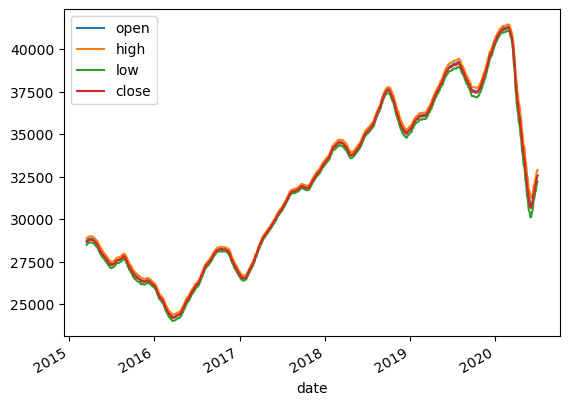

In [50]:
rollingwindows(50, bse_data).plot()
plt.show()

In [51]:
altdata_fiftydays = rollingwindows(50, bse_data)
altdata_fiftydays.reset_index(inplace=True)
altdata_fiftydays.rename(columns={list(altdata_fiftydays)[0]:'date'}, inplace=True)

In [52]:
alt.Chart(altdata_fiftydays).mark_point().encode(
    x='date',
    y='close'
)

alt.Chart(...)

In [53]:
def boolean_shock(percent, df, col):
  data = df.filter(['date', col], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data['percentchg'] = (data[col].pct_change()) * 100  #percentage change compare to previous volume using pct_change() function
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(col, axis = 1, inplace = True)
  return data.dropna()

In [54]:
boolean_shock(10, bse_data, 'volume')

,percentchg,shock
date,,
2015-01-05,24.324324,1
2015-01-06,53.260870,1
2015-01-07,-13.475177,0
2015-01-08,-32.786885,0
2015-01-09,35.365854,1
...,...,...
2020-06-23,0.398406,0
2020-06-24,5.555556,0
2020-06-25,-7.518797,0


In [55]:
altdata_volpercentchg = boolean_shock(10, bse_data, 'volume')
altdata_volpercentchg.reset_index(inplace=True)
altdata_volpercentchg.rename(columns={list(altdata_volpercentchg)[0]:'date'}, inplace=True)

In [56]:
alt.Chart(altdata_volpercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

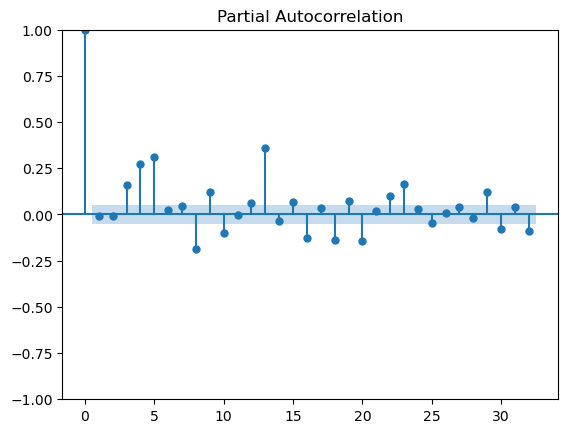

In [57]:
plotvolpercentchg = altdata_volpercentchg.filter(['date', 'percentchg'], axis=1) #df.copy()
plotvolpercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_volpercentchg['date']))) 
del plotvolpercentchg['date']
sm.graphics.tsa.plot_pacf(plotvolpercentchg.values.squeeze())
plt.show()

In [58]:
boolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [59]:
altdata_closepercentchg2 = boolean_shock(2, bse_data, 'close')
altdata_closepercentchg2.reset_index(inplace=True)
altdata_closepercentchg2.rename(columns={list(altdata_closepercentchg2)[0]:'date'}, inplace=True)

In [60]:
alt.Chart(altdata_closepercentchg2).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

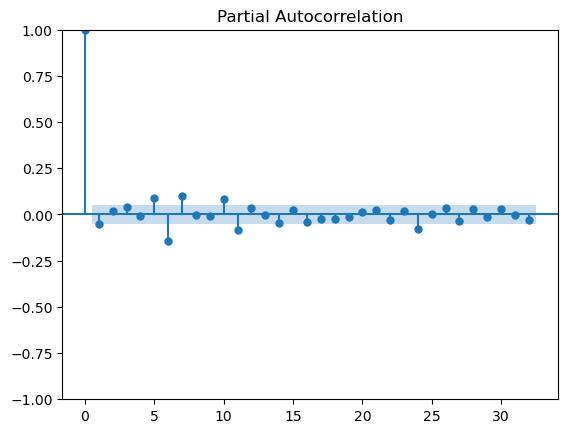

In [61]:
plotclosepercentchg2 = altdata_closepercentchg2.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg2.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg2['date']))) 
del plotclosepercentchg2['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg2.values.squeeze())
plt.show()

In [62]:
boolean_shock(10, bse_data, 'close')

,percentchg,shock
date,,
2015-01-05,-0.163440,0
2015-01-06,-3.070360,0
2015-01-07,-0.291397,0
2015-01-08,1.359742,0
2015-01-09,0.673407,0
...,...,...
2020-06-23,1.486937,0
2020-06-24,-1.584653,0
2020-06-25,-0.077085,0


In [63]:
altdata_closepercentchg10 = boolean_shock(10, bse_data, 'close')
altdata_closepercentchg10.reset_index(inplace=True)
altdata_closepercentchg10.rename(columns={list(altdata_closepercentchg10)[0]:'date'}, inplace=True)

In [64]:
alt.Chart(altdata_closepercentchg10).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

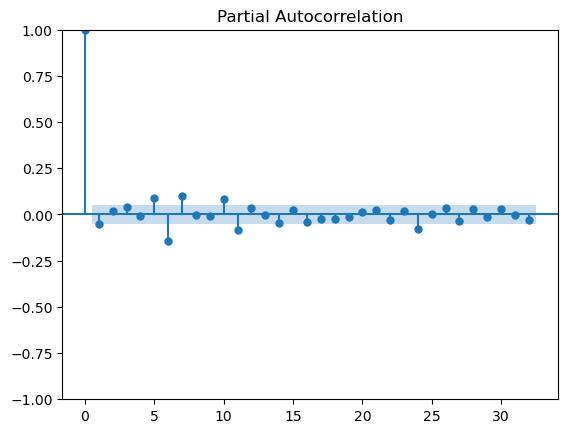

In [65]:
plotclosepercentchg10 = altdata_closepercentchg10.filter(['date', 'percentchg'], axis=1) #df.copy()
plotclosepercentchg10.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_closepercentchg10['date']))) 
del plotclosepercentchg10['date']
sm.graphics.tsa.plot_pacf(plotclosepercentchg10.values.squeeze())
plt.show()

In [66]:
def priceboolean_shock(percent, df):
  df['date'] = pd.to_datetime(df['date'])
  data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data['priceavg'] = (data['high'] + data['low'] + data['close']) / 3
  data['shock'] = (data['priceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
  return data

In [67]:
priceboolean_shock(10, bse_data)

,priceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,0
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [68]:
altdata_pricepercentchg = priceboolean_shock(10, bse_data)
altdata_pricepercentchg.reset_index(inplace=True)
altdata_pricepercentchg.rename(columns={list(altdata_pricepercentchg)[0]:'date'}, inplace=True)

In [69]:
alt.Chart(altdata_pricepercentchg).mark_point().encode(
    x='date',
    y='priceavg'
)

alt.Chart(...)

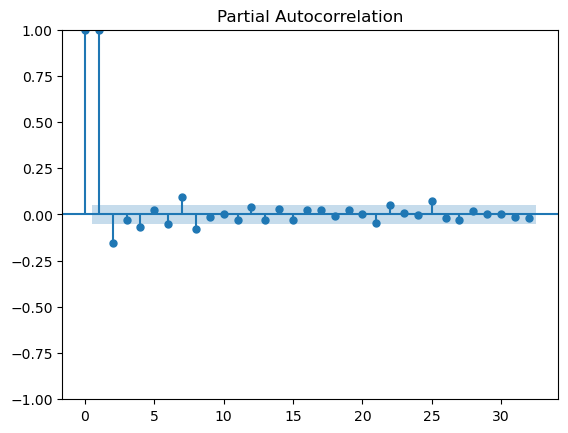

In [70]:
plotpricepercentchg = altdata_pricepercentchg.filter(['date', 'priceavg'], axis=1) #df.copy()
plotpricepercentchg.index = pd.Index(sm.tsa.datetools.dates_from_range('2015', length=len(altdata_pricepercentchg['date']))) 
del plotpricepercentchg['date']
sm.graphics.tsa.plot_pacf(plotpricepercentchg.values.squeeze())
plt.show()

In [71]:
def reverseboolean_shock(percent, df, col):
  data = df.filter(['date', col], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['percentchg'] = (data[col].pct_change()) * 100
  data['shock'] = data['percentchg'].apply(lambda x: 1 if x > percent else 0)
  data.drop(col, axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [72]:
reverseboolean_shock(2, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,1
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [73]:
altdata_closepercentchg = reverseboolean_shock(2, bse_data, 'close')
altdata_closepercentchg.reset_index(inplace=True)
altdata_closepercentchg.rename(columns={list(altdata_closepercentchg)[0]:'date'}, inplace=True)

In [74]:
alt.Chart(altdata_closepercentchg).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [75]:
reverseboolean_shock(5, bse_data, 'close')

,percentchg,shock
date,,
2015-01-02,0.163708,0
2015-01-05,3.167617,0
2015-01-06,0.292249,0
2015-01-07,-1.341501,0
2015-01-08,-0.668903,0
...,...,...
2020-06-22,-1.465151,0
2020-06-23,1.610168,0
2020-06-24,0.077145,0


In [76]:
altdata_closepercentchg5 = reverseboolean_shock(5, bse_data, 'close')
altdata_closepercentchg5.reset_index(inplace=True)
altdata_closepercentchg5.rename(columns={list(altdata_closepercentchg5)[0]:'date'}, inplace=True)

In [77]:
alt.Chart(altdata_closepercentchg5).mark_point().encode(
    x='date',
    y='percentchg'
)

alt.Chart(...)

In [78]:
def pricereverseboolean_shock(percent, df):
  data = df.filter(['date', 'high', 'low','close'], axis=1) #df.copy()
  data.set_index('date', inplace=True)
  data = data.reindex(index=data.index[::-1])
  data['reversepriceavg'] = (data['high'] + data['low'] + data['close']) / 3
  data['shock'] = (data['reversepriceavg'].pct_change()) * 100
  data['shock'] = data['shock'].apply(lambda x: 1 if x >= percent else 0)
  data.drop(['high', 'low', 'close'], axis = 1, inplace = True)
  data = data.reindex(index=data.index[::-1])
  return data.dropna()

In [79]:
pricereverseboolean_shock(2, bse_data)

,reversepriceavg,shock
date,,
2015-01-02,27781.543620,0
2015-01-05,27897.886719,1
2015-01-06,27207.817057,0
2015-01-07,26912.179688,0
2015-01-08,27231.020182,0
...,...,...
2020-06-23,35252.093750,0
2020-06-24,35123.486979,0
2020-06-25,34807.830729,0


In [80]:
altdata_reversepricepercentchg = pricereverseboolean_shock(2, bse_data)
altdata_reversepricepercentchg.reset_index(inplace=True)
altdata_reversepricepercentchg.rename(columns={list(altdata_reversepricepercentchg)[0]:'date'}, inplace=True)

In [81]:
alt.Chart(altdata_reversepricepercentchg).mark_point().encode(
    x='date',
    y='reversepriceavg'
)

alt.Chart(...)

In [82]:
#textual analysis
news  = pd.read_csv('/Users/jaishreeram/Desktop/india-news-headlines.csv')

In [83]:
news.columns

Index(['publish_date', 'headline_category', 'headline_text'], dtype='object')

In [84]:
news.shape

(3650970, 3)

In [85]:
news.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [86]:
news['headline_category'].unique()

array(['unknown', 'entertainment.hindi.bollywood', 'india', ...,
       'sports.football.euro-2021', 'business.markets.ipo',
       'sports.tokyo-olympics.india-in-tokyo'], dtype=object)

In [87]:
#checking all the values count (unique values total count)
news['headline_category'].value_counts()

india                                                    297491
unknown                                                  209583
city.mumbai                                              150451
city.delhi                                               137648
business.india-business                                  121195
                                                          ...  
nepal-india-earthquake.opinion                                8
elections.lok-sabha-elections-2019.tripura.news               8
best-products.home-decor-and-garden.living-room-decor         8
profiles.india-profiles                                       8
pms-us-visit                                                  8
Name: headline_category, Length: 1041, dtype: int64

In [88]:
#finding if any null values are present
news.isnull().sum().sum()

0

In [89]:
#finding if any duplicate values are present
news.duplicated().sum()

24860

In [90]:
#rough checking by marking all duplicates as True. Default is first which marks duplicates as True except for the first occurrence.
news.duplicated(keep=False).sum()

47452

In [91]:
#sorting the dataset to delete the duplicates, to make duplicates come together one after another. The sorted dataset index values are also changed
cols = list(news.columns)
news.sort_values(by=cols, inplace=True, ignore_index=True)

In [92]:
news[news.duplicated(keep=False)]

,publish_date,headline_category,headline_text
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,America's unwanted heading for India?
5,20010102,unknown,America's unwanted heading for India?
6,20010102,unknown,America's unwanted heading for India?
9,20010102,unknown,BBC's reality TV will focus on AIIMS
...,...,...,...
3646165,20220322,city.hubballi,BJP divided over probable induction of Basavar...
3648600,20220327,city.chennai,Father; daughter killed in TN as e-bike on cha...
3648601,20220327,city.chennai,Father; daughter killed in TN as e-bike on cha...
3649664,20220329,city.hyderabad,Telangana logs 30 new Covid cases


In [93]:
news.drop_duplicates(keep='last', inplace=True, ignore_index=True)

In [94]:
#re-checking everything worked well with drop_duplicates() carried out earlier on the dataset
news.duplicated().sum()

0

In [96]:
pip install textblob

  Obtaining dependency information for textblob from https://files.pythonhosted.org/packages/02/07/5fd2945356dd839974d3a25de8a142dc37293c21315729a41e775b5f3569/textblob-0.18.0.post0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 7.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [97]:
from textblob import TextBlob

In [98]:
#getting a list of unique dates in publish_date column
lst = news['publish_date'].value_counts().index.tolist()

In [99]:
#concatenating all the headline_text column values of same date in publish_date column
new = []
for x in lst:
  df = news.loc[news['publish_date'] == x]
  headlinetext = ''
  publishdate = str(x)
  headlinetext = df['headline_text'].iloc[0]
  for i in range(1 , len(df)):
    headlinetext = headlinetext + '. '+ df['headline_text'].iloc[i]  
  new.append(headlinetext)

In [100]:
#creating a new dataset
newsdf = pd.DataFrame({'publish_date': lst, 'headline_text' : new})

In [101]:

newsdf

,publish_date,headline_text
0,20141215,Golden Homes III. Golden Panorama. Hanging Gar...
1,20141221,Eight companies add Rs 55;171 crore in m-cap; ...
2,20141209,Audi-Vredestein driving experience. Benelli TN...
3,20141129,6 CARE IPO merchant bankers fined Rs 1 crore. ...
4,20141227,New generation Audi Q7 being tested in India. ...
...,...,...
7712,20010302,Such A Long Journey
7713,20010525,What Women Want
7714,20010605,Darkness Triumphs
7715,20010316,Tape and Tell


In [102]:
newsdf.sort_values(by='publish_date', inplace=True, ignore_index=True)

In [103]:
newsdf.head()

,publish_date,headline_text
0,20010102,Raju Chacha. A noisy effort to spruce up Comme...
1,20010103,'Devdas': Jinxed?. 10-year-old girl missing. 3...
2,20010104,Car dealers caught in Bihar sales tax ruling. ...
3,20010105,Nepal won't allow anti-India activities: Envoy...
4,20010106,Anti-immigration think-tank berates Clinton re...


In [114]:
polarity = []
subjectivity = []
for idx, row in newsdf.iterrows():
  polarity.append(TextBlob(row['headline_text']).sentiment[0])
  subjectivity.append(TextBlob(row['headline_text']).sentiment[1])

In [115]:
newsdf['polarity'] = polarity
newsdf['subjectivity'] = subjectivity

In [116]:
newsdf.head()

,publish_date,headline_text,polarity,subjectivity
0,20010102,Raju Chacha. A noisy effort to spruce up Comme...,0.193519,0.293056
1,20010103,'Devdas': Jinxed?. 10-year-old girl missing. 3...,0.088462,0.407692
2,20010104,Car dealers caught in Bihar sales tax ruling. ...,0.091426,0.481895
3,20010105,Nepal won't allow anti-India activities: Envoy...,0.257415,0.465542
4,20010106,Anti-immigration think-tank berates Clinton re...,0.219481,0.464935


In [117]:
newsdf.rename(columns={'publish_date': 'date'}, inplace = True)

In [122]:
newsdf = newsdf.filter(['date', 'polarity', 'subjectivity'], axis=1)

In [123]:
newsdf['date'].duplicated().sum()

0

In [124]:
bse_data.shape

(1345, 7)

In [128]:
newsdf.head()

,date,polarity,subjectivity
0,20010102,0.193519,0.293056
1,20010103,0.088462,0.407692
2,20010104,0.091426,0.481895
3,20010105,0.257415,0.465542
4,20010106,0.219481,0.464935


In [131]:
newsdf['date'] = pd.to_datetime(newsdf['date'], format='%Y%m%d')

In [132]:
newsdf.head()

,date,polarity,subjectivity
0,2001-01-02,0.193519,0.293056
1,2001-01-03,0.088462,0.407692
2,2001-01-04,0.091426,0.481895
3,2001-01-05,0.257415,0.465542
4,2001-01-06,0.219481,0.464935


In [133]:
bse_data = pd.merge(bse_data, newsdf, how='left', on=['date'])

In [134]:
bse_data.head()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,0.055586,0.455251
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,0.100081,0.433132
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,0.055802,0.386579
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,0.034707,0.386916
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,0.060173,0.408416


In [135]:
#adding new row for 30th June 2020 (price to be predicted of this day) to main dataset to get average values of all the columns for this day
#taking average because we don't know the values of all the columns for tomorrow so to predict we need average for independent variable.
#We will separate this row later from this main dataset so we can use this as prediction of unseen data for tomorrow. 
#And then tally it with actual data from unseenbse_data dataset which we have downloaded too for 30th June 2020 actual values
bse_data.loc[len(bse_data)] = ['2020-06-30', bse_data['open'].mean(), bse_data['high'].mean(), bse_data['low'].mean(),
                       bse_data['close'].mean(), bse_data['adjclose'].mean(), bse_data['volume'].median(), newsdf['polarity'].mean(), newsdf['subjectivity'].mean() ]

In [136]:
bse_data['date'] = pd.to_datetime(bse_data['date'], format="%Y-%m-%d")

In [137]:
bse_data.tail()

,date,open,high,low,close,adjclose,volume,polarity,subjectivity
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.980469,34868.980469,26600.0,0.088329,0.387802
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.101562,34842.101562,24600.0,0.023232,0.401736
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.269531,35171.269531,24800.0,0.069594,0.381331
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.519531,34961.519531,18300.0,0.056935,0.387858
1345,2020-06-30,32032.534800,32180.642524,31806.772791,31984.237075,31984.237075,12700.0,0.068447,0.402597


In [138]:
bse_data["month"] = bse_data['date'].dt.month
bse_data["day"] = bse_data['date'].dt.day
bse_data["dayofweek"] = bse_data['date'].dt.dayofweek
bse_data["week"] = bse_data['date'].dt.week
bse_data['movingavg4weeks'] = round(bse_data['close'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
bse_data['movingavg16weeks'] = round(bse_data['close'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
bse_data['movingavg28weeks'] = round(bse_data['close'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
bse_data['movingavg40weeks'] = round(bse_data['close'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
bse_data['movingavg52weeks'] = round(bse_data['close'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
bse_data['window10days'] = round(bse_data['close'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
bse_data['window50days'] = round(bse_data['close'].rolling(window = 50, min_periods = 1).mean().shift(),2)
bse_data['volumeshock'] = round(boolean_shock(10, bse_data, 'volume').reset_index()['shock'], 2)
bse_data['closeshock2'] = round(reverseboolean_shock(2, bse_data, 'close').reset_index()['shock'], 2)
bse_data['closeshock5'] = round(reverseboolean_shock(5, bse_data, 'close').reset_index()['shock'],2)
bse_data['closeshock10'] = round(reverseboolean_shock(10, bse_data, 'close').reset_index()['shock'], 2)
bse_data['priceshock'] = round(priceboolean_shock(10, bse_data).reset_index()['shock'], 2)
bse_data['reversebooleanshock2'] = round(reverseboolean_shock(2, bse_data, 'close').reset_index()['shock'], 2)
bse_data['reversebooleanshock5'] = round(reverseboolean_shock(5, bse_data, 'close').reset_index()['shock'], 2)
bse_data['pricereverseshock2'] = round(pricereverseboolean_shock(2, bse_data).reset_index()['shock'], 2)
bse_data['polarity'] = round(bse_data['polarity'] , 2)
bse_data['subjectivity'] = round(bse_data['subjectivity'] , 2)
bse_data['price'] = round((bse_data['high'] + bse_data['low'] + bse_data['close']) / 3 , 2)
bse_data['close'] = round(bse_data['close'] , 2)

In [139]:
bse_data

,date,open,high,low,close,adjclose,volume,polarity,subjectivity,month,...,window50days,volumeshock,closeshock2,closeshock5,closeshock10,priceshock,reversebooleanshock2,reversebooleanshock5,pricereverseshock2,price
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.90,27887.900391,7400.0,0.06,0.46,1,...,NaN,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27781.54
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.32,27842.320312,9200.0,0.10,0.43,1,...,27887.90,1.0,1.0,0.0,0.0,0,1.0,0.0,1,27897.89
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.46,26987.460938,14100.0,0.06,0.39,1,...,27865.11,0.0,0.0,0.0,0.0,0,0.0,0.0,0,27207.82
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.82,26908.820312,12200.0,0.03,0.39,1,...,27572.56,0.0,0.0,0.0,0.0,0,0.0,0.0,0,26912.18
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.71,27274.710938,8200.0,0.06,0.41,1,...,27406.63,1.0,0.0,0.0,0.0,0,0.0,0.0,0,27231.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,2020-06-24,35679.738281,35706.550781,34794.929688,34868.98,34868.980469,26600.0,0.09,0.39,6,...,32303.70,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35123.49
1342,2020-06-25,34525.390625,35081.609375,34499.781250,34842.10,34842.101562,24600.0,0.02,0.40,6,...,32377.89,0.0,0.0,0.0,0.0,0,0.0,0.0,0,34807.83
1343,2020-06-26,35144.781250,35254.878906,34910.339844,35171.27,35171.269531,24800.0,0.07,0.38,6,...,32460.93,0.0,0.0,0.0,0.0,0,0.0,0.0,0,35112.16
1344,2020-06-29,34926.949219,35032.359375,34662.058594,34961.52,34961.519531,18300.0,0.06,0.39,6,...,32556.76,0.0,1.0,1.0,0.0,0,1.0,1.0,1,34885.31


In [140]:
bse_data.fillna(method = 'bfill', inplace = True)

In [141]:
bse_data.fillna(method = 'ffill', inplace = True)

In [142]:
bse_data.isnull().sum().sum()

0

In [143]:
bse_data = bse_data.filter(['month', 'day', 'dayofweek', 'week',
       'movingavg4weeks', 'movingavg16weeks', 'movingavg28weeks',
       'movingavg40weeks', 'movingavg52weeks', 'window10days', 'window50days',
       'volumeshock', 'closeshock2', 'closeshock5', 'closeshock10',
       'priceshock', 'reversebooleanshock2', 'reversebooleanshock5',
       'pricereverseshock2', 'polarity', 'subjectivity', 'price', 'close'], axis=1)

In [144]:
main_bsedata = bse_data.iloc[:1345,:].reset_index()  
newtestunseen_bsedata = bse_data.iloc[1345:,:].reset_index()  

In [145]:
main_bsedata.shape

(1345, 24)

In [146]:
newtestunseen_bsedata.shape

(1, 24)

In [147]:
#Training the model and predicting the price of tomorrow 30th June 2020

In [148]:
X = main_bsedata.drop(['price','close'], axis = 1)
y = main_bsedata[['price','close']]

In [149]:
Xnewtestunseen = newtestunseen_bsedata.drop(['price','close'], axis = 1)
ynewtestunseen_ans = newtestunseen_bsedata[['price','close']]

In [150]:
X.shape, y.shape

((1345, 22), (1345, 2))

In [151]:
Xnewtestunseen.shape, ynewtestunseen_ans.shape

((1, 22), (1, 2))

In [152]:
split = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [153]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1076, 22), (1076, 2), (269, 22), (269, 2))

In [182]:
rfg = RandomForestRegressor(random_state = 42, n_estimators = 500, criterion='squared_error', max_depth = 30, min_samples_leaf=2, min_samples_split=5, n_jobs=1)

In [183]:
chainedmodel = RegressorChain(rfg)
chainedmodel.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=30,
                                                    min_samples_leaf=2,
                                                    min_samples_split=5,
                                                    n_estimators=500, n_jobs=1,
                                                    random_state=42))

In [184]:
pred = chainedmodel.predict(X_test)
roundpred = []
for x in range(len(pred)):
  roundpred.append([round(pred[x][0], 2),round(pred[x][1], 2) ])

In [185]:
r2_score(y_test, roundpred) 

0.9946490121434016

In [186]:
print('MAE')
print(mean_absolute_error(y_test, roundpred), end='\n')
#MSE
print('MSE')
print(mean_squared_error(y_test, roundpred), end='\n')
#RMSE
print('RMSE')
print(np.sqrt(mean_squared_error(y_test, roundpred)))

MAE
255.83503717472112
MSE
129688.06349126398
RMSE
360.12228963404084


In [187]:
pred_newtestunseen = chainedmodel.predict(Xnewtestunseen)

In [188]:
[(round(pred_newtestunseen[0][0], 2)),(round(pred_newtestunseen[0][1], 2))]

[35069.6, 34984.28]

In [189]:
ynewtestunseen_ans  #used average of high, low, close, volume to calculate price ((high+low+close)/3) and close value

,price,close
0,31990.55,31984.24


In [190]:
[unseenbsedata_price[0] , round(unseenbse_data['close'],2)[0]] #actual price ((high+low+close)/3) calculated earlier and the closing price

[34987.5, 34915.8]

In [191]:
#The model predicted for 30th June 2020 the price ((high+low+close)/3) i.e the average of high, low, close of BSE index to be 35020.02 and closing price to be 34955.46

#And the actual price ((high+low+close)/3) i.e the average of high, low, close of BSE index on day 30th June 2020 was 34987.5, and closing price was 34915.8

#So as seen above our model has done a very good prediction